## Нейронные сети (продолжение)
Пензин М.С.

penzin.ml.tsu@gmail.com

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
from matplotlib import pyplot as plt

## Tensorflow

__[Tensorflow](https://www.tensorflow.org/)__ - это весьма мощная библиотека для машинного обучения от Google, позволяющая эффективно строить и обучать различные нейронные сети.

__[Google Colab](https://colab.research.google.com)__ - бесплатная платформа для запуска кода (предоставляется доступ к одному TPU или GPU).

In [4]:
import tensorflow as tf

In [5]:
# базовые элементы

const = tf.constant(2.0, name="const")
    
b = tf.Variable(2.0, name='b')
c = tf.Variable(1, dtype=tf.float32, name='c')

x = tf.placeholder(shape=(), dtype=tf.float32, name="x")

In [6]:
print(const)
print(b)
print(b + c)
print(x)

Tensor("const:0", shape=(), dtype=float32)
<tf.Variable 'b:0' shape=() dtype=float32_ref>
Tensor("add:0", shape=(), dtype=float32)
Tensor("x:0", shape=(), dtype=float32)


In [473]:
a = b + c
z = a + x

In [117]:
with tf.Session() as sess:
    r = sess.run(const)    
    print(r)

2.0


In [120]:
with tf.Session() as sess:
    sess.run(b.initializer)
    sess.run(c.initializer)
    r = sess.run(a)    
    print(r)

3.0


In [121]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    r = sess.run(a)    
    print(r)

3.0


In [123]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    r = sess.run(z, feed_dict={x: 3})    
    print(r)

6.0


In [124]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    r = sess.run(z, feed_dict={x: 3, b: 5})    
    print(r)

9.0


## Пример работы с Tensorflow

В прошлый раз мы реализовывали нейронную сеть средствами numpy. Попробуем для этого теперь использовать tensorflow.

In [474]:
# Загрузис маленький кусок данных

import pickle

f = open("../data/mnist.pkl3", "rb")
X, y = pickle.load(f), pickle.load(f)
f.close()

X = X / 255
y = np.array(list(map(int, y)))

In [475]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# проведем one-hot кодирование

y = to_categorical(y, 10)
X_t, X_v, y_t, y_v = train_test_split(X, y)

Альтернативно, мы можем с помощью Keras загрузить один из встроенных наборов данных.

In [261]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [476]:
# Для начала объявим входные параметры и целевые исходы

X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

In [7]:
# Веса каждого слоя
Ws = [
    tf.Variable(tf.random_normal([784, 30], mean=0.0, stddev=0.01), name="W1", dtype=tf.float32),
    tf.Variable(tf.random_normal([30, 10], mean=0.0, stddev=0.01), name="W2", dtype=tf.float32),
]

# Смещения каждого слоя
Bs = [
    tf.Variable(tf.random_normal([30,], mean=0.0, stddev=0.01), name="B1", dtype=tf.float32),
    tf.Variable(tf.random_normal([10,], mean=0.0, stddev=0.01), name="B2", dtype=tf.float32),
]

In [8]:
# Layer 1
layer = tf.matmul(X, Ws[0]) + Bs[0]
layer = tf.nn.relu(layer)

#Layer 2
layer = tf.matmul(layer, Ws[1]) + Bs[1]
output = tf.nn.softmax(layer)

In [477]:
# Уберем 100 % уверенность сети
y_c = tf.clip_by_value(output, 1e-6, 0.999999)

# Функция потерь
loss = - tf.reduce_mean(
    tf.reduce_sum(
        Y * tf.log(y_c)
        + 
        (1 - Y) * tf.log(1 - y_c), 
        axis=1,
    )
)

In [478]:
# Выбираем алгоритм оптимизации

#optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
optimiser = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

In [479]:
# Метрика качества

correct_prediction = tf.equal(tf.argmax(Y, axis=1), tf.argmax(output, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [251]:
epochs = 100
batch_size = 10

acc_hist = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    steps = int(X_t.shape[0] / batch_size)
    
    for epoch in range(epochs):
        print("Epoch #%d" % epoch)
        
        avg_loss = 0
        avg_acc = 0
        for step in range(steps):
            batch_x = X_t[step*batch_size: (step+1)*batch_size]
            batch_y = y_t[step*batch_size: (step+1)*batch_size]

            _, acc, c = sess.run([optimiser, accuracy, loss], feed_dict={X: batch_x, Y: batch_y})

            avg_acc += acc
            avg_loss += c
        avg_loss /= steps
        avg_acc /= steps
        print("\t loss = %.6f" % avg_loss)
        print("\t acc  = %.6f" % avg_acc)
        v_acc, v_loss = sess.run([accuracy, loss], feed_dict={X: X_v, Y: y_v})
        print("\t valid loss = %.6f" % v_loss)
        print("\t valid acc  = %.6f" % v_acc)
        acc_hist.append((avg_acc, v_acc))
        

Epoch #0
	 loss = 1.533350
	 acc  = 0.674000
	 valid loss = 0.827274
	 valid acc  = 0.834000
Epoch #1
	 loss = 0.643036
	 acc  = 0.879333
	 valid loss = 0.802592
	 valid acc  = 0.858000
Epoch #2
	 loss = 0.445054
	 acc  = 0.923333
	 valid loss = 0.885179
	 valid acc  = 0.864000
Epoch #3
	 loss = 0.384035
	 acc  = 0.934000
	 valid loss = 0.746826
	 valid acc  = 0.890000
Epoch #4
	 loss = 0.254111
	 acc  = 0.954667
	 valid loss = 0.846273
	 valid acc  = 0.896000
Epoch #5
	 loss = 0.178707
	 acc  = 0.971333
	 valid loss = 0.951914
	 valid acc  = 0.888000
Epoch #6
	 loss = 0.136881
	 acc  = 0.980000
	 valid loss = 1.003152
	 valid acc  = 0.878000
Epoch #7
	 loss = 0.114951
	 acc  = 0.984667
	 valid loss = 1.031283
	 valid acc  = 0.870000
Epoch #8
	 loss = 0.142137
	 acc  = 0.976000
	 valid loss = 1.015849
	 valid acc  = 0.880000
Epoch #9
	 loss = 0.136850
	 acc  = 0.976667
	 valid loss = 0.896184
	 valid acc  = 0.890000
Epoch #10
	 loss = 0.256081
	 acc  = 0.953333
	 valid loss = 1.692217


	 loss = 0.000015
	 acc  = 1.000000
	 valid loss = 1.655526
	 valid acc  = 0.894000
Epoch #89
	 loss = 0.000015
	 acc  = 1.000000
	 valid loss = 1.657396
	 valid acc  = 0.894000
Epoch #90
	 loss = 0.000014
	 acc  = 1.000000
	 valid loss = 1.659023
	 valid acc  = 0.894000
Epoch #91
	 loss = 0.000014
	 acc  = 1.000000
	 valid loss = 1.655335
	 valid acc  = 0.894000
Epoch #92
	 loss = 0.000014
	 acc  = 1.000000
	 valid loss = 1.657959
	 valid acc  = 0.894000
Epoch #93
	 loss = 0.000014
	 acc  = 1.000000
	 valid loss = 1.660089
	 valid acc  = 0.894000
Epoch #94
	 loss = 0.000013
	 acc  = 1.000000
	 valid loss = 1.661801
	 valid acc  = 0.896000
Epoch #95
	 loss = 0.000013
	 acc  = 1.000000
	 valid loss = 1.663086
	 valid acc  = 0.896000
Epoch #96
	 loss = 0.000013
	 acc  = 1.000000
	 valid loss = 1.660736
	 valid acc  = 0.896000
Epoch #97
	 loss = 0.000013
	 acc  = 1.000000
	 valid loss = 1.663029
	 valid acc  = 0.896000
Epoch #98
	 loss = 0.000013
	 acc  = 1.000000
	 valid loss = 1.664331


In [252]:
acc_hist = np.array(acc_hist)

plt.plot(acc_hist[:, 0], label="train")
plt.plot(acc_hist[:, 1], label="test")
plt.grid()
plt.legend()
plt.show()

Еще одной очень приятной возможностью Tensorflow является возможность сохранения состояния сети.

In [14]:
epochs = 5
batch_size = 10

saver = tf.train.Saver()

init = tf.global_variables_initializer() 

with tf.Session() as sess:
    sess.run(init)
    
    steps = int(X_t.shape[0] / batch_size)

    for epoch in range(epochs):        
        for step in range(steps):
            batch_x = X_t[step*batch_size: (step+1)*batch_size]
            batch_y = y_t[step*batch_size: (step+1)*batch_size]

            _, acc, c = sess.run([optimiser, accuracy, loss], feed_dict={X: batch_x, Y: batch_y})

    v_acc, v_loss = sess.run([accuracy, loss], feed_dict={X: X_v, Y: y_v})
    print("valid loss = %.6f" % v_loss)
    print("valid acc  = %.6f" % v_acc)
        
    save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in path: %s" % save_path)


valid loss = 0.827902
valid acc  = 0.890000
Model saved in path: ./model.ckpt


In [16]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./model.ckpt")
    v_acc, v_loss = sess.run([accuracy, loss], feed_dict={X: X_v, Y: y_v})
    print("valid loss = %.6f" % v_loss)
    print("valid acc  = %.6f" % v_acc)
    
#valid loss = 0.827902
#valid acc  = 0.890000

INFO:tensorflow:Restoring parameters from ./model.ckpt
valid loss = 0.827902
valid acc  = 0.890000


## Keras

**Keras** - высокоуровневая надстройка над Tensorflow для программирования нейронных сетей.

In [7]:
# Для чистоты, снова загрузим сырые данные
from tensorflow.keras.datasets import mnist

(X_t, y_t), (X_v, y_v) = mnist.load_data()
X_t = X_t / 255
X_v = X_v / 255

(60000, 28, 28)


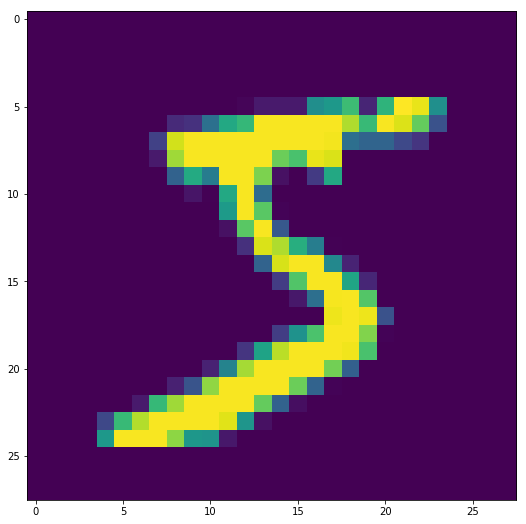

In [19]:
print(X_t.shape)
plt.imshow(X_t[0])

## Последовательный стиль

При данном подходе мы просто создаем последовательно необходимые слои друг за другом

In [20]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [23]:
model = Sequential([
    Flatten(),
    Dense(30, activation=tf.nn.relu),
    Dense(10, activation="softmax")
])

# А могли просто по порядку вызывать add
#model.add(Dense(30))

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_t, y_t, epochs=50, verbose=2, validation_data=(X_v, y_v));

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 3s - loss: 0.3650 - acc: 0.8982 - val_loss: 0.2170 - val_acc: 0.9357
Epoch 2/50
 - 3s - loss: 0.1875 - acc: 0.9463 - val_loss: 0.1665 - val_acc: 0.9494
Epoch 3/50
 - 3s - loss: 0.1471 - acc: 0.9571 - val_loss: 0.1403 - val_acc: 0.9585
Epoch 4/50
 - 3s - loss: 0.1217 - acc: 0.9649 - val_loss: 0.1237 - val_acc: 0.9624
Epoch 5/50
 - 3s - loss: 0.1070 - acc: 0.9687 - val_loss: 0.1219 - val_acc: 0.9637
Epoch 6/50
 - 3s - loss: 0.0952 - acc: 0.9715 - val_loss: 0.1087 - val_acc: 0.9663
Epoch 7/50
 - 3s - loss: 0.0865 - acc: 0.9738 - val_loss: 0.1160 - val_acc: 0.9661
Epoch 8/50
 - 3s - loss: 0.0800 - acc: 0.9758 - val_loss: 0.1067 - val_acc: 0.9689
Epoch 9/50
 - 3s - loss: 0.0742 - acc: 0.9781 - val_loss: 0.1042 - val_acc: 0.9671
Epoch 10/50
 - 3s - loss: 0.0695 - acc: 0.9787 - val_loss: 0.1109 - val_acc: 0.9684
Epoch 11/50
 - 3s - loss: 0.0654 - acc: 0.9795 - val_loss: 0.1046 - val_acc: 0.9704
Epoch 12/50
 - 3s - loss: 0.0604 - 

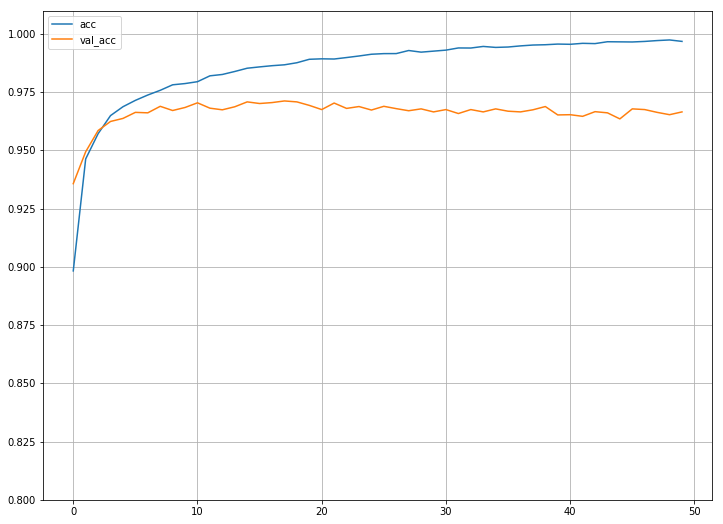

In [25]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.grid()
plt.ylim([0.8, 1.01])
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(X_v, y_v)

print(test_loss, test_acc)

10000/10000 [==============================] - 0s 32us/step
0.18234416215254715 0.9665


## Функциональный стиль

В данном стиле мы сами соединяем все элементы сети. Позволяет создавать более сложные структуры сети.

In [29]:
# Вход
inputs = tf.keras.Input(shape=(28, 28))
flat = tf.keras.layers.Flatten()(inputs)

# Скрытый слой слой
x = tf.keras.layers.Dense(30, activation=tf.nn.relu)(flat)
# Вывод
outputs = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(x)

# Модель
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_t, y_t, epochs=10, verbose=2, validation_data=(X_v, y_v));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.3526 - acc: 0.9024 - val_loss: 0.2119 - val_acc: 0.9388
Epoch 2/10
 - 3s - loss: 0.1902 - acc: 0.9455 - val_loss: 0.1637 - val_acc: 0.9528
Epoch 3/10
 - 3s - loss: 0.1494 - acc: 0.9560 - val_loss: 0.1387 - val_acc: 0.9602
Epoch 4/10
 - 3s - loss: 0.1263 - acc: 0.9631 - val_loss: 0.1292 - val_acc: 0.9624
Epoch 5/10
 - 3s - loss: 0.1113 - acc: 0.9668 - val_loss: 0.1195 - val_acc: 0.9647
Epoch 6/10
 - 3s - loss: 0.0996 - acc: 0.9702 - val_loss: 0.1148 - val_acc: 0.9669
Epoch 7/10
 - 3s - loss: 0.0898 - acc: 0.9730 - val_loss: 0.1073 - val_acc: 0.9683
Epoch 8/10
 - 3s - loss: 0.0826 - acc: 0.9745 - val_loss: 0.1062 - val_acc: 0.9694
Epoch 9/10
 - 3s - loss: 0.0758 - acc: 0.9764 - val_loss: 0.1083 - val_acc: 0.9679
Epoch 10/10
 - 3s - loss: 0.0702 - acc: 0.9781 - val_loss: 0.1030 - val_acc: 0.9693


## Автокодировщики

В простейшем случае - это обычный многослойные персептрон, у которого число входов совпадает с числом выходом. При этом при обучении, мы обучаем сеть так, чтобы воспроизводить данные полученные на входе.

<center>
    <img src="../img/ae.png">
</center>

## Для чего?

* предобучение нейронных сетей
* компрессия данных
* сглаживание данных
* формирование признаков

Почитать обзор с примерами можно __[здесь](https://habr.com/ru/post/331382/)__ 

In [32]:
# Кодировщик
inputs = tf.keras.Input(shape=(28, 28))
flat = Flatten()(inputs)
encoded = Dense(49, activation='relu')(flat)

encoder = tf.keras.Model(inputs, encoded, name="encoder")

# Декодер
input_decoder = tf.keras.Input(shape=(49,))
decoded = Dense(784, activation='sigmoid')(input_decoder)
output = tf.keras.layers.Reshape((28, 28))(decoded)

decoder = tf.keras.Model(input_decoder, output, name="decoder")

# Автокодировщик
autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)), name="autoencoder")

In [33]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 49)                38465     
_________________________________________________________________
decoder (Model)              (None, 28, 28)            39200     
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [36]:
autoencoder.compile(optimizer=tf.train.AdamOptimizer(), 
                    loss='binary_crossentropy')
autoencoder.fit(X_t, X_t, epochs=10, verbose=1);

Epoch 1/10
60000/60000 [==============================] - 8s 135us/step - loss: 0.0811
Epoch 2/10
60000/60000 [==============================] - 8s 125us/step - loss: 0.0805
Epoch 3/10
60000/60000 [==============================] - 8s 137us/step - loss: 0.0801
Epoch 4/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0800
Epoch 5/10
60000/60000 [==============================] - 9s 145us/step - loss: 0.0798
Epoch 6/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.0797
Epoch 7/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0796
Epoch 8/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.0795
Epoch 9/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0795
Epoch 10/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.0794


In [37]:
X_p = autoencoder.predict(X_v[:30])

plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(3, 8, 1 + 2 * i)
    plt.title("Before")
    plt.imshow(X_v[i].reshape((28, 28)))
    plt.subplot(3, 8, 1 + 2 * i + 1)
    plt.title("After")
    plt.imshow(X_p[i].reshape((28, 28)))
    
plt.show()

In [39]:
enc = encoder.predict(X_v)
enc.shape

(10000, 49)

Можно обучить автокодировщик для убирания шума.

In [40]:
X_n = X_t + np.random.normal(0.5, 0.5, X_t.shape)
X_n = np.clip(X_n, 0, 1)
autoencoder.compile(optimizer=tf.train.AdamOptimizer(), 
                    loss='binary_crossentropy')
autoencoder.fit(X_n, X_t, epochs=10);

Epoch 1/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.1741
Epoch 2/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.1365
Epoch 3/10
60000/60000 [==============================] - 8s 136us/step - loss: 0.1317
Epoch 4/10
60000/60000 [==============================] - 9s 144us/step - loss: 0.1299
Epoch 5/10
60000/60000 [==============================] - 9s 145us/step - loss: 0.1289
Epoch 6/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1283
Epoch 7/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1278
Epoch 8/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.1274
Epoch 9/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1271
Epoch 10/10
60000/60000 [==============================] - 8s 136us/step - loss: 0.1269


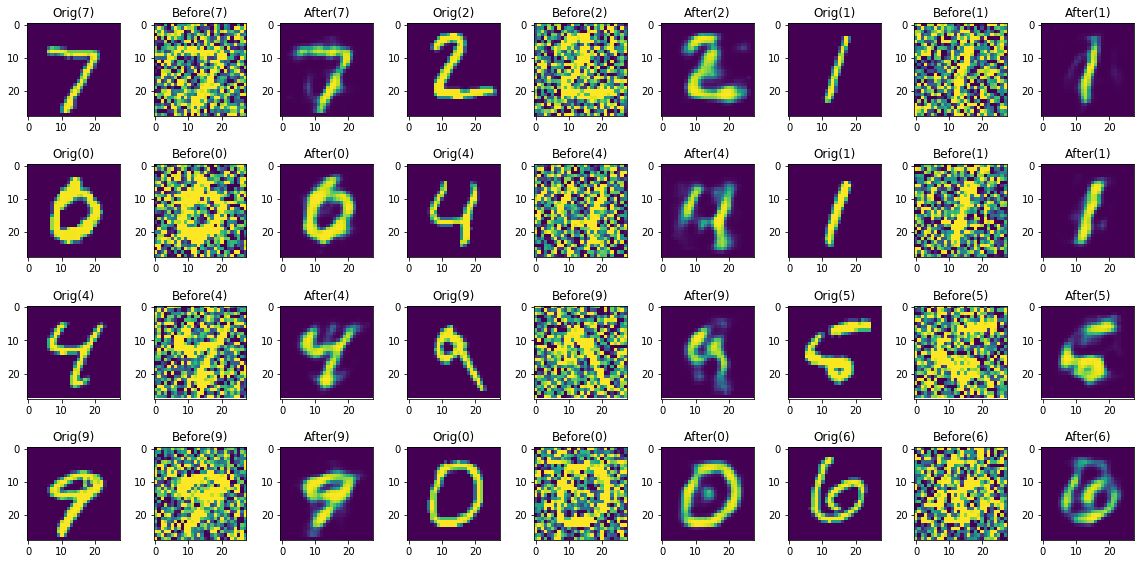

In [46]:
X_i = X_v[:30] + np.random.normal(0.5, 0.5, X_v[:30].shape)
X_i = np.clip(X_i, 0, 1)
X_p = autoencoder.predict(X_i)

plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(4, 9, 1 + 3 * i)
    plt.title("Orig(%d)" % y_v[i])
    plt.imshow(X_v[i])
    
    plt.subplot(4, 9, 1 + 3 * i + 1)
    plt.title("Before(%d)" % y_v[i])
    plt.imshow(X_i[i])
    
    plt.subplot(4, 9, 1 + 3 * i + 2)
    plt.title("After(%d)" % y_v[i])
    plt.imshow(X_p[i])
plt.tight_layout()    
plt.show()

## Сверточные сети

**Convolution Neural Network** - это специальная архитектура нейронных сетей, называемая так благодаря использованию операции свертки

<center>
    <img src="../img/cat.png">
</center>

## Свертка

Это довольно простая операция, активно используемая цифровыми фильтрами.

$$
y_{i, j} = \sum_{k, m} \omega_{k,m} x_{i+k, j+m}
$$

где $\omega$ - коэффициенты ядра свертки

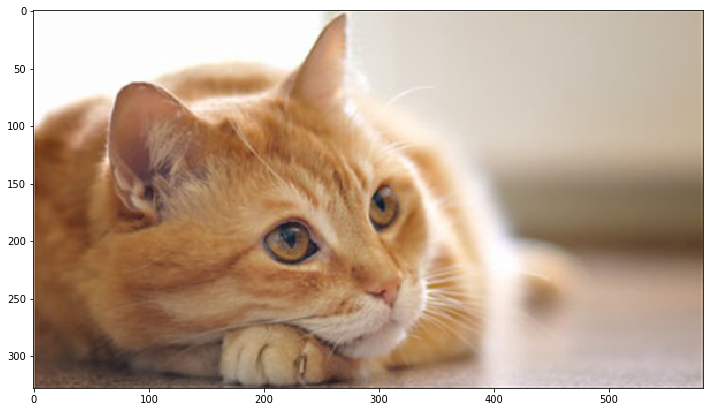

In [48]:
from scipy import ndimage

img = ndimage.imread("../img/cat.jpeg")
img = img / 255
plt.imshow(img);

Рассмотрим простое ядро

In [49]:
K = np.array(
    [[ -1, -1, -1],
     [ -1,  8, -1],
     [ -1, -1, -1]],
)

In [50]:
new_img = np.zeros(img.shape)

new_img[:,:,0] = ndimage.convolve(img[:,:,0], K, mode='constant', cval=0.0)
new_img[:,:,1] = ndimage.convolve(img[:,:,1], K, mode='constant', cval=0.0)
new_img[:,:,2] = ndimage.convolve(img[:,:,2], K, mode='constant', cval=0.0)

new_img = np.clip(new_img, 0, 1)

In [51]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(new_img)
plt.show()

А теперь вернемся к нейронным сетям. Представим входное изображение в виде матрицы входных нейронов.
<center>
    <img src="../img/tikz42.png">
</center>

Дальше ядром проходим по всем нейронам, свертка с которым становится входным значением для нейронов следующего слоя. При этом ядро используется везде одно и тоже.

<center>
    <img src="../img/tikz44.png">
</center>

<center>
    <img src="../img/tikz45.png">
</center>

Если у нас было изображение 28х28, то после свертки с ядром 5х5, мы получим матрицу значений 24х24. Сигнал нейрона в следующем слое можно представить как:

$$
y_{i,j} = \sum_{m,n} \omega_{m, n} y_{i+m, j+n} + b
$$

Фактически, мы пытаемся обнаружить некий признак, который соответвует ядру свертки. В результате получая карту признака (feature map). Основным преимуществом является то, что при этом не очень важно где на изображении находится искомый признак.

<center>
    <img src="../img/filter.png">
</center>

<center>
    <img src="../img/mice.png">
</center>

<center>
    <img src="../img/part1.png">
</center>

<center>
    <img src="../img/part2.png">
</center>

И ничего не мешает взять несколько ядер

<center>
    <img src="../img/tikz46.png">
</center>

Такой подход значительно уменьшает количество настраиваемых параметров. Для сравнения, в примере выше на одну признаковую карту уходит 26 параметров. Для полносвязной сети со скрытым слоем из 30 нейронов уходило бы 23550 параметров.

## Слои подвыборки

**Pooling layer** - позволяет уменьшить размерность данных. Применяется после сверточного слоя. По факту - это просто скользящее окно с какой-то агрегирующей функцией (обычно avg или max).

<center>
    <img src="../img/poolingmax.png">
</center>

<center>
    <img src="../img/poolingaverage.png">
</center>

Таким образом, при использовании окна 2х2, после pooling layer из 24х24 остается матрица 12х12.

## LeNet-5

Попробуем реализовать одну из популярных нейронных сетей для распознования рукописных цифр - __[LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)__

<center>
    <img src="../img/lenet5.png">
</center>

In [52]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten

model = Sequential()

# Первый сверточный блок
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(32, 32, 1)))
model.add(AveragePooling2D((2, 2)))

# Второй сверточный блок
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu'))
model.add(AveragePooling2D((2, 2)))

# Разворачиваем изображение в вектор
model.add(Flatten())

# Полносвязные слои
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_25 (Dense)             (None, 84)                10164     
__________

In [54]:
X_prep = X_t.reshape((-1, 28, 28, 1))
X_prep = np.pad(X_prep, ((0,0),(2,2),(2,2),(0,0)), 'constant') / 255

X_prep_v = X_v.reshape((-1, 28, 28, 1))
X_prep_v = np.pad(X_prep_v, ((0,0),(2,2),(2,2),(0,0)), 'constant') / 255

In [57]:
%%time

# Обучаем
model.fit(X_prep, y_t, validation_data=(X_prep_v, y_v), epochs=10, verbose=1);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 538us/step - loss: 0.1783 - acc: 0.9440 - val_loss: 0.1501 - val_acc: 0.9523
Epoch 2/10
60000/60000 [==============================] - 33s 552us/step - loss: 0.1465 - acc: 0.9539 - val_loss: 0.1356 - val_acc: 0.9560
Epoch 3/10
60000/60000 [==============================] - 30s 494us/step - loss: 0.1255 - acc: 0.9602 - val_loss: 0.1053 - val_acc: 0.9674
Epoch 4/10
60000/60000 [==============================] - 29s 489us/step - loss: 0.1110 - acc: 0.9649 - val_loss: 0.1029 - val_acc: 0.9668
Epoch 5/10
60000/60000 [==============================] - 31s 509us/step - loss: 0.0993 - acc: 0.9683 - val_loss: 0.0906 - val_acc: 0.9703
Epoch 6/10
60000/60000 [==============================] - 29s 486us/step - loss: 0.0906 - acc: 0.9709 - val_loss: 0.0848 - val_acc: 0.9717
Epoch 7/10
60000/60000 [==============================] - 30s 505us/step - loss: 0.0841 - acc: 0.9733 - val_loss: 0.

In [61]:
model.evaluate(X_prep_v, y_v)

10000/10000 [==============================] - 3s 289us/step


[0.07152999037448317, 0.9776]

In [62]:
# Сохраняем модель целиком в один файл формата HDF5
model.save('lanet5.h5')

In [63]:
# Восстаналиваем ту же самую модель, включая веса и оптимизатор
model = tf.keras.models.load_model('lanet5.h5')

In [71]:
def plot_conv_weights(model, layer_name, channel=0):
    W = model.get_layer(name=layer_name).get_weights()[0]
    plt.figure()
    rows = int(W.shape[-1] / 5) + 1
    for i in range(W.shape[-1]):
        plt.subplot(rows, 5, i + 1)
        plt.imshow(W[:,:,channel, i])
    plt.tight_layout()
    plt.show()

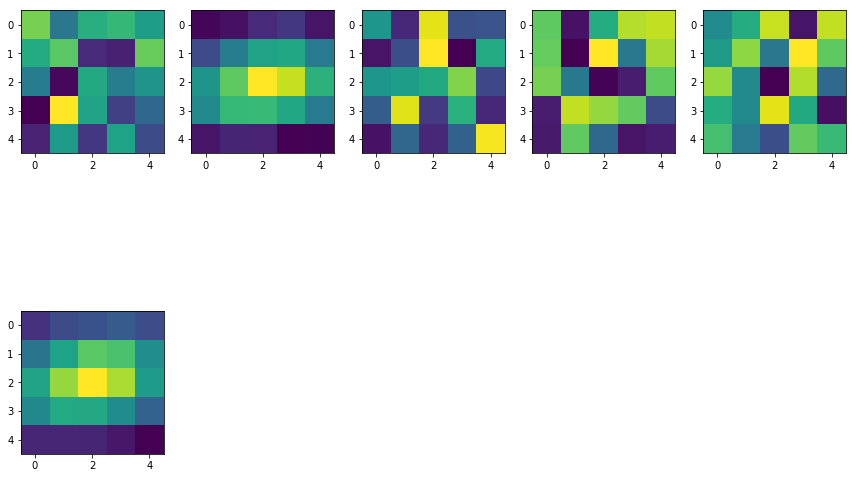

In [72]:
plot_conv_weights(model, 'conv2d')

## Рекуррентные нейронные сети

**Reccurent Neural Network** - достаточно интересный вид нейронных сетей, в который каждый нейрон получает сигнал с собственного выхода, но с задержкой.

В простейшем виде реккурентный нейрон можно представить так
<center>
    <img src="../img/rnn.jpg">
</center>

Формульно это запишеться как (один из вариантов)

$$
\vec{o}_t = f_o(\mathbf{V} \, \vec{s}_t) \\
\vec{s}_t = f_s(\mathbf{W} \, \vec{s}_{t-1} + \mathbf{U} \, \vec{x}_t)
$$

как же это обучать?

а все так же, обратным распространение ошибки, но во времени (Backpropagation Through Time)

Для чего можно использовать

* анализ последовательностей
* анализ и синтез речи
* анализ текстов
* фильтры
* и много другое

## LSTM

**Long short-term memory** - долгая краткосрочная память, умеет отслеживать события, что разнесены на достаточно большом промежутке времени. 

Отличается от предыдущего случая введением вектора внутреннего состояния $C_t$

### Обычный RNN

<center>
    <img src="../img/rnn0.png">
</center>

### LSTM

<center>
    <img src="../img/lstm.png">
</center>

<center>
    <img src="../img/lstm-notation.png">
</center>

## Forget gate

Вентиль забывания - решает какие данные стоит забыть из прошлого

<center>
    <img src="../img/lstm-forget.png">
</center>

## Input gate

Вентиль входных данных - решает, какие данные нужно обновить

<center>
    <img src="../img/lstm-input.png">
</center>

Формируем новое состояние

<center>
    <img src="../img/lstm-new.png">
</center>

## Output gate

Вентиль выходных данных - решает, что необходимо показать на выходе

<center>
    <img src="../img/lstm-output.png">
</center>

## Пример

In [74]:
df = pd.read_csv("../data/AirPassengers.csv", index_col="Month", parse_dates=['Month'])
df.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

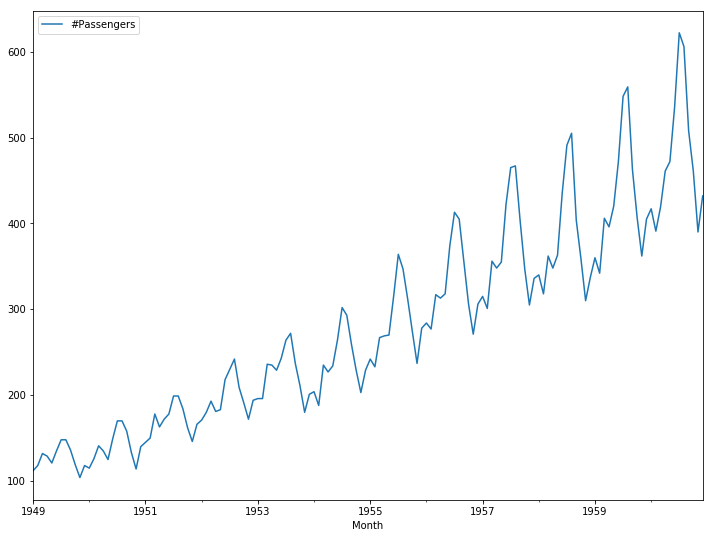

In [75]:
df.plot();

In [76]:
from tensorflow.keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [128]:
scaler = MinMaxScaler(feature_range=(0, 1))

data = df.values.astype('float32')
data = scaler.fit_transform(data)

M = int(0.67 * data.shape[0])
train, test = data[:M], data[M:]

In [79]:
def convert(data, look_back=1):
    dataX, dataY = [], []
    for i in range(data.shape[0] - look_back):
        a = data[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

look_back = 12

X_t, y_t = convert(train, look_back)
X_v, y_v = convert(test, look_back)

print(X_t[0], y_t[0])
print(X_t[1], y_t[1])
print(X_t[2], y_t[2])

[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753 0.         0.02702703] 0.021235526
[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
 0.08494207 0.06177607 0.02895753 0.         0.02702703 0.02123553] 0.042471036
[0.05405405 0.04826255 0.03281853 0.05984557 0.08494207 0.08494207
 0.06177607 0.02895753 0.         0.02702703 0.02123553 0.04247104] 0.07142857


In [80]:
# LSTM принимает данные в виде (samples, time_serises, features)

X_t = np.reshape(X_t, (X_t.shape[0], X_t.shape[1], 1))
X_v = np.reshape(X_v, (X_v.shape[0], X_v.shape[1], 1))

In [82]:
tf.keras.optimizers.Adam?

In [103]:
model = Sequential()

model.add(LSTM(32, input_shape=(look_back, 1), return_sequences=False))
#model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
model.fit(X_t, y_t, epochs=2000, verbose=2)

Epoch 1/2000
 - 4s - loss: 0.0681
Epoch 2/2000
 - 0s - loss: 0.0435
Epoch 3/2000
 - 0s - loss: 0.0242
Epoch 4/2000
 - 0s - loss: 0.0139
Epoch 5/2000
 - 0s - loss: 0.0128
Epoch 6/2000
 - 0s - loss: 0.0120
Epoch 7/2000
 - 0s - loss: 0.0160
Epoch 8/2000
 - 0s - loss: 0.0174
Epoch 9/2000
 - 0s - loss: 0.0098
Epoch 10/2000
 - 0s - loss: 0.0121
Epoch 11/2000
 - 0s - loss: 0.0125
Epoch 12/2000
 - 0s - loss: 0.0106
Epoch 13/2000
 - 0s - loss: 0.0091
Epoch 14/2000
 - 0s - loss: 0.0116
Epoch 15/2000
 - 0s - loss: 0.0119
Epoch 16/2000
 - 0s - loss: 0.0112
Epoch 17/2000
 - 0s - loss: 0.0087
Epoch 18/2000
 - 0s - loss: 0.0091
Epoch 19/2000
 - 0s - loss: 0.0075
Epoch 20/2000
 - 0s - loss: 0.0074
Epoch 21/2000
 - 0s - loss: 0.0080
Epoch 22/2000
 - 0s - loss: 0.0081
Epoch 23/2000
 - 0s - loss: 0.0078
Epoch 24/2000
 - 0s - loss: 0.0080
Epoch 25/2000
 - 0s - loss: 0.0083
Epoch 26/2000
 - 0s - loss: 0.0070
Epoch 27/2000
 - 0s - loss: 0.0079
Epoch 28/2000
 - 0s - loss: 0.0074
Epoch 29/2000
 - 0s - loss: 0

Epoch 232/2000
 - 0s - loss: 0.0039
Epoch 233/2000
 - 0s - loss: 0.0044
Epoch 234/2000
 - 0s - loss: 0.0046
Epoch 235/2000
 - 0s - loss: 0.0028
Epoch 236/2000
 - 0s - loss: 0.0040
Epoch 237/2000
 - 0s - loss: 0.0047
Epoch 238/2000
 - 0s - loss: 0.0038
Epoch 239/2000
 - 0s - loss: 0.0040
Epoch 240/2000
 - 0s - loss: 0.0031
Epoch 241/2000
 - 0s - loss: 0.0026
Epoch 242/2000
 - 0s - loss: 0.0037
Epoch 243/2000
 - 0s - loss: 0.0039
Epoch 244/2000
 - 0s - loss: 0.0031
Epoch 245/2000
 - 0s - loss: 0.0029
Epoch 246/2000
 - 0s - loss: 0.0047
Epoch 247/2000
 - 0s - loss: 0.0033
Epoch 248/2000
 - 0s - loss: 0.0039
Epoch 249/2000
 - 0s - loss: 0.0037
Epoch 250/2000
 - 0s - loss: 0.0025
Epoch 251/2000
 - 0s - loss: 0.0029
Epoch 252/2000
 - 0s - loss: 0.0026
Epoch 253/2000
 - 0s - loss: 0.0032
Epoch 254/2000
 - 0s - loss: 0.0031
Epoch 255/2000
 - 0s - loss: 0.0032
Epoch 256/2000
 - 0s - loss: 0.0032
Epoch 257/2000
 - 0s - loss: 0.0026
Epoch 258/2000
 - 0s - loss: 0.0027
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0025
Epoch 461/2000
 - 0s - loss: 0.0020
Epoch 462/2000
 - 0s - loss: 0.0026
Epoch 463/2000
 - 0s - loss: 0.0024
Epoch 464/2000
 - 0s - loss: 0.0019
Epoch 465/2000
 - 0s - loss: 0.0018
Epoch 466/2000
 - 0s - loss: 0.0017
Epoch 467/2000
 - 0s - loss: 0.0023
Epoch 468/2000
 - 0s - loss: 0.0024
Epoch 469/2000
 - 0s - loss: 0.0020
Epoch 470/2000
 - 0s - loss: 0.0025
Epoch 471/2000
 - 0s - loss: 0.0023
Epoch 472/2000
 - 0s - loss: 0.0024
Epoch 473/2000
 - 0s - loss: 0.0019
Epoch 474/2000
 - 0s - loss: 0.0027
Epoch 475/2000
 - 0s - loss: 0.0022
Epoch 476/2000
 - 0s - loss: 0.0027
Epoch 477/2000
 - 0s - loss: 0.0027
Epoch 478/2000
 - 0s - loss: 0.0024
Epoch 479/2000
 - 0s - loss: 0.0019
Epoch 480/2000
 - 0s - loss: 0.0025
Epoch 481/2000
 - 0s - loss: 0.0028
Epoch 482/2000
 - 0s - loss: 0.0022
Epoch 483/2000
 - 0s - loss: 0.0029
Epoch 484/2000
 - 0s - loss: 0.0025
Epoch 485/2000
 - 0s - loss: 0.0024
Epoch 486/2000
 - 0s - loss: 0.0032
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0020
Epoch 689/2000
 - 0s - loss: 0.0017
Epoch 690/2000
 - 0s - loss: 0.0023
Epoch 691/2000
 - 0s - loss: 0.0021
Epoch 692/2000
 - 0s - loss: 0.0021
Epoch 693/2000
 - 0s - loss: 0.0024
Epoch 694/2000
 - 0s - loss: 0.0019
Epoch 695/2000
 - 0s - loss: 0.0018
Epoch 696/2000
 - 0s - loss: 0.0019
Epoch 697/2000
 - 0s - loss: 0.0018
Epoch 698/2000
 - 0s - loss: 0.0017
Epoch 699/2000
 - 0s - loss: 0.0020
Epoch 700/2000
 - 0s - loss: 0.0019
Epoch 701/2000
 - 0s - loss: 0.0016
Epoch 702/2000
 - 0s - loss: 0.0024
Epoch 703/2000
 - 0s - loss: 0.0019
Epoch 704/2000
 - 0s - loss: 0.0025
Epoch 705/2000
 - 0s - loss: 0.0026
Epoch 706/2000
 - 0s - loss: 0.0021
Epoch 707/2000
 - 0s - loss: 0.0020
Epoch 708/2000
 - 0s - loss: 0.0025
Epoch 709/2000
 - 0s - loss: 0.0025
Epoch 710/2000
 - 0s - loss: 0.0026
Epoch 711/2000
 - 0s - loss: 0.0017
Epoch 712/2000
 - 0s - loss: 0.0024
Epoch 713/2000
 - 0s - loss: 0.0021
Epoch 714/2000
 - 0s - loss: 0.0021
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0017
Epoch 917/2000
 - 0s - loss: 0.0015
Epoch 918/2000
 - 0s - loss: 0.0017
Epoch 919/2000
 - 0s - loss: 0.0021
Epoch 920/2000
 - 0s - loss: 0.0020
Epoch 921/2000
 - 0s - loss: 0.0017
Epoch 922/2000
 - 0s - loss: 0.0018
Epoch 923/2000
 - 0s - loss: 0.0023
Epoch 924/2000
 - 0s - loss: 0.0017
Epoch 925/2000
 - 0s - loss: 0.0018
Epoch 926/2000
 - 0s - loss: 0.0014
Epoch 927/2000
 - 0s - loss: 0.0016
Epoch 928/2000
 - 0s - loss: 0.0023
Epoch 929/2000
 - 0s - loss: 0.0014
Epoch 930/2000
 - 0s - loss: 0.0021
Epoch 931/2000
 - 0s - loss: 0.0018
Epoch 932/2000
 - 0s - loss: 0.0018
Epoch 933/2000
 - 0s - loss: 0.0017
Epoch 934/2000
 - 0s - loss: 0.0020
Epoch 935/2000
 - 0s - loss: 0.0019
Epoch 936/2000
 - 0s - loss: 0.0018
Epoch 937/2000
 - 0s - loss: 0.0016
Epoch 938/2000
 - 0s - loss: 0.0019
Epoch 939/2000
 - 0s - loss: 0.0017
Epoch 940/2000
 - 0s - loss: 0.0018
Epoch 941/2000
 - 0s - loss: 0.0019
Epoch 942/2000
 - 0s - loss: 0.0019
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0018
Epoch 1141/2000
 - 0s - loss: 0.0021
Epoch 1142/2000
 - 0s - loss: 0.0017
Epoch 1143/2000
 - 0s - loss: 0.0014
Epoch 1144/2000
 - 0s - loss: 0.0021
Epoch 1145/2000
 - 0s - loss: 0.0017
Epoch 1146/2000
 - 0s - loss: 0.0012
Epoch 1147/2000
 - 0s - loss: 0.0020
Epoch 1148/2000
 - 0s - loss: 0.0018
Epoch 1149/2000
 - 0s - loss: 0.0017
Epoch 1150/2000
 - 0s - loss: 0.0017
Epoch 1151/2000
 - 0s - loss: 0.0015
Epoch 1152/2000
 - 0s - loss: 0.0016
Epoch 1153/2000
 - 0s - loss: 0.0016
Epoch 1154/2000
 - 0s - loss: 0.0015
Epoch 1155/2000
 - 0s - loss: 0.0015
Epoch 1156/2000
 - 0s - loss: 0.0014
Epoch 1157/2000
 - 0s - loss: 0.0014
Epoch 1158/2000
 - 0s - loss: 0.0017
Epoch 1159/2000
 - 0s - loss: 0.0015
Epoch 1160/2000
 - 0s - loss: 0.0016
Epoch 1161/2000
 - 0s - loss: 0.0021
Epoch 1162/2000
 - 0s - loss: 0.0021
Epoch 1163/2000
 - 0s - loss: 0.0016
Epoch 1164/2000
 - 0s - loss: 0.0017
Epoch 1165/2000
 - 0s - loss: 0.0015
Epoch 1166/2000
 - 0s - loss: 0.0016
E

 - 0s - loss: 0.0016
Epoch 1362/2000
 - 0s - loss: 0.0014
Epoch 1363/2000
 - 0s - loss: 0.0016
Epoch 1364/2000
 - 0s - loss: 0.0013
Epoch 1365/2000
 - 0s - loss: 0.0013
Epoch 1366/2000
 - 0s - loss: 0.0019
Epoch 1367/2000
 - 0s - loss: 0.0012
Epoch 1368/2000
 - 0s - loss: 0.0019
Epoch 1369/2000
 - 0s - loss: 0.0016
Epoch 1370/2000
 - 0s - loss: 0.0013
Epoch 1371/2000
 - 0s - loss: 0.0018
Epoch 1372/2000
 - 0s - loss: 0.0014
Epoch 1373/2000
 - 0s - loss: 0.0015
Epoch 1374/2000
 - 0s - loss: 0.0014
Epoch 1375/2000
 - 0s - loss: 0.0014
Epoch 1376/2000
 - 0s - loss: 0.0013
Epoch 1377/2000
 - 0s - loss: 0.0017
Epoch 1378/2000
 - 0s - loss: 0.0019
Epoch 1379/2000
 - 0s - loss: 0.0013
Epoch 1380/2000
 - 0s - loss: 0.0016
Epoch 1381/2000
 - 0s - loss: 0.0014
Epoch 1382/2000
 - 0s - loss: 0.0014
Epoch 1383/2000
 - 0s - loss: 0.0013
Epoch 1384/2000
 - 0s - loss: 0.0013
Epoch 1385/2000
 - 0s - loss: 0.0012
Epoch 1386/2000
 - 0s - loss: 0.0013
Epoch 1387/2000
 - 0s - loss: 0.0018
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0019
Epoch 1584/2000
 - 0s - loss: 0.0018
Epoch 1585/2000
 - 0s - loss: 0.0019
Epoch 1586/2000
 - 0s - loss: 0.0015
Epoch 1587/2000
 - 0s - loss: 0.0016
Epoch 1588/2000
 - 0s - loss: 0.0015
Epoch 1589/2000
 - 0s - loss: 0.0021
Epoch 1590/2000
 - 0s - loss: 0.0015
Epoch 1591/2000
 - 0s - loss: 0.0012
Epoch 1592/2000
 - 0s - loss: 0.0013
Epoch 1593/2000
 - 0s - loss: 0.0015
Epoch 1594/2000
 - 0s - loss: 0.0013
Epoch 1595/2000
 - 0s - loss: 0.0012
Epoch 1596/2000
 - 0s - loss: 0.0020
Epoch 1597/2000
 - 0s - loss: 0.0014
Epoch 1598/2000
 - 0s - loss: 0.0015
Epoch 1599/2000
 - 0s - loss: 0.0015
Epoch 1600/2000
 - 0s - loss: 0.0020
Epoch 1601/2000
 - 0s - loss: 0.0013
Epoch 1602/2000
 - 0s - loss: 0.0015
Epoch 1603/2000
 - 0s - loss: 0.0016
Epoch 1604/2000
 - 0s - loss: 0.0014
Epoch 1605/2000
 - 0s - loss: 0.0017
Epoch 1606/2000
 - 0s - loss: 0.0014
Epoch 1607/2000
 - 0s - loss: 0.0017
Epoch 1608/2000
 - 0s - loss: 0.0015
Epoch 1609/2000
 - 0s - loss: 0.0020
E

Epoch 1805/2000
 - 0s - loss: 0.0014
Epoch 1806/2000
 - 0s - loss: 0.0013
Epoch 1807/2000
 - 0s - loss: 0.0014
Epoch 1808/2000
 - 0s - loss: 0.0015
Epoch 1809/2000
 - 0s - loss: 0.0016
Epoch 1810/2000
 - 0s - loss: 0.0016
Epoch 1811/2000
 - 0s - loss: 0.0016
Epoch 1812/2000
 - 0s - loss: 0.0011
Epoch 1813/2000
 - 0s - loss: 0.0012
Epoch 1814/2000
 - 0s - loss: 0.0012
Epoch 1815/2000
 - 0s - loss: 0.0015
Epoch 1816/2000
 - 0s - loss: 0.0013
Epoch 1817/2000
 - 0s - loss: 0.0014
Epoch 1818/2000
 - 0s - loss: 0.0015
Epoch 1819/2000
 - 0s - loss: 0.0016
Epoch 1820/2000
 - 0s - loss: 0.0017
Epoch 1821/2000
 - 0s - loss: 0.0015
Epoch 1822/2000
 - 0s - loss: 0.0016
Epoch 1823/2000
 - 0s - loss: 0.0015
Epoch 1824/2000
 - 0s - loss: 0.0016
Epoch 1825/2000
 - 0s - loss: 0.0013
Epoch 1826/2000
 - 0s - loss: 0.0016
Epoch 1827/2000
 - 0s - loss: 9.5227e-04
Epoch 1828/2000
 - 0s - loss: 0.0012
Epoch 1829/2000
 - 0s - loss: 0.0013
Epoch 1830/2000
 - 0s - loss: 0.0013
Epoch 1831/2000
 - 0s - loss: 0.00

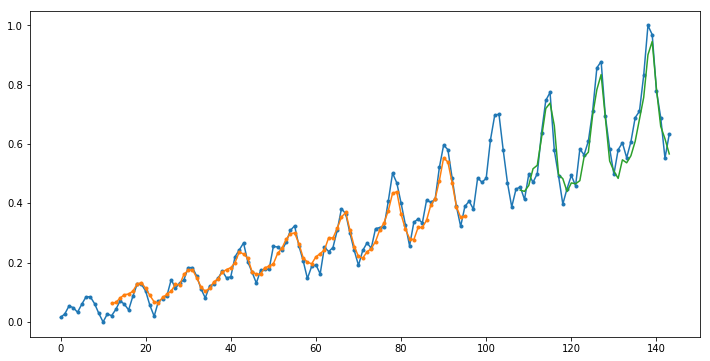

In [104]:
plt.figure(figsize=(12,6))
plt.plot(data, ".-")

X_1 = model.predict(X_t)
plt.plot(np.arange(look_back, look_back + X_1.shape[0]), X_1.ravel(), ".-")

X_2 = model.predict(X_v)
plt.plot(np.arange(2 * look_back + X_1.shape[0], 
                   2 * look_back + X_1.shape[0] + X_2.shape[0]), X_2.ravel())
plt.show()